In [1]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, re, time, math, tqdm, itertools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
import keras
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint

# Loading the Data

In [2]:
network_data1 = pd.read_csv('deeplearning/02-15-2018.csv', low_memory=False)
network_data2 = pd.read_csv('deeplearning/02-16-2018.csv', low_memory=False)
network_data3 = pd.read_csv('deeplearning/02-20-2018.csv', low_memory=False)
network_data4 = pd.read_csv('deeplearning/02-21-2018.csv', low_memory=False)
print(network_data3.head(10))


# not needed
network_data3.drop(columns=['Flow ID', 'Src IP', 'Src Port', 'Dst IP'], axis=1,inplace=True)



network_data = pd.concat([network_data1, network_data2], axis=0)
network_data.reset_index(drop=True, inplace=True)
del network_data1, network_data2
print('packets 1 and 2 finished')

network_data = pd.concat([network_data, network_data3], axis=0)
network_data.reset_index(drop=True, inplace=True)
del network_data3
print('packet 3 finished')

network_data = pd.concat([network_data, network_data4], axis=0)
network_data.reset_index(drop=True, inplace=True)
del network_data4
print('packet 4 finished')

ParserError: Error tokenizing data. C error: out of memory

Most of the network intrusions in our data are benign, as output from above code cell. 

## Data Visualizations
After getting some useful information about our data, we now make visuals of our data to see how the trend in our data goes like. The visuals include bar plots, distribution plots, scatter plots, etc.

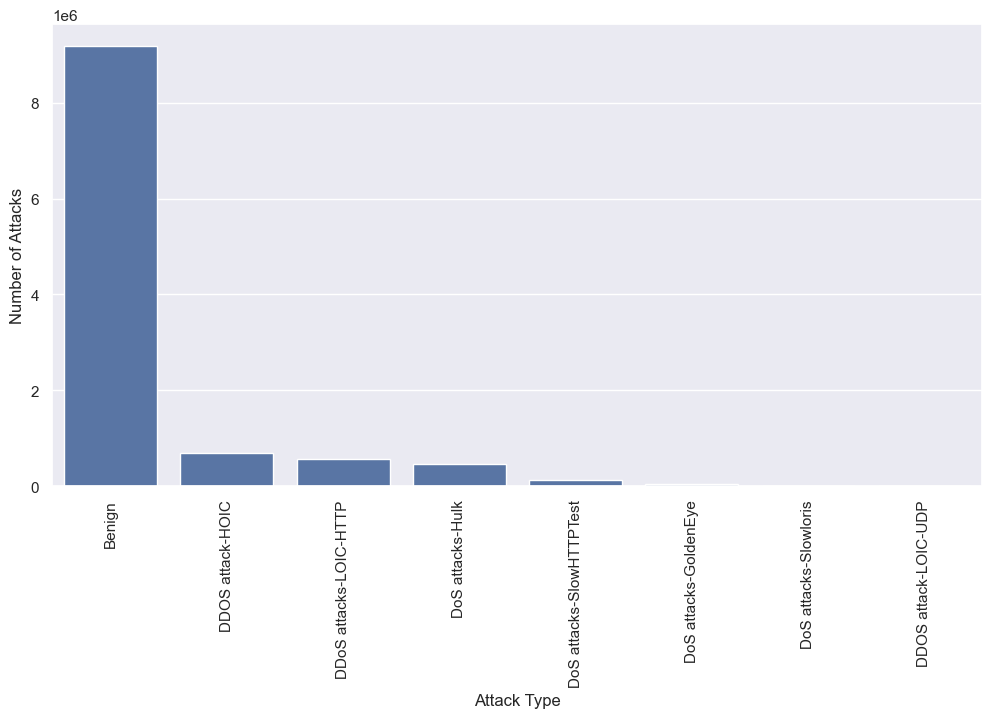

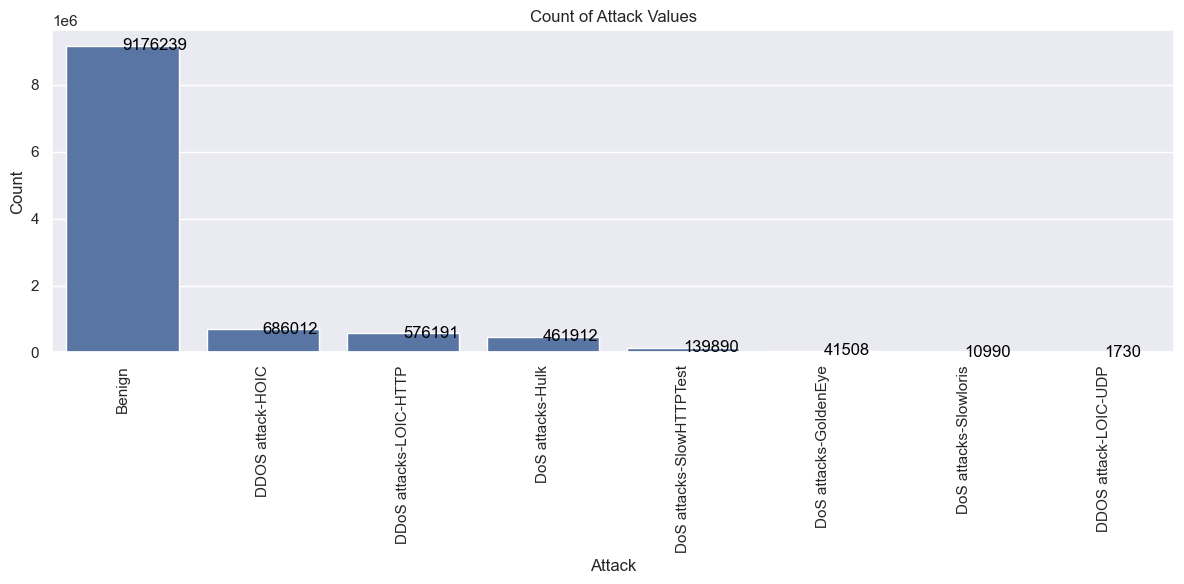

In [ ]:
# make a plot number of labels
sns.set(rc={'figure.figsize':(12, 6)})
plt.xlabel('Attack Type')
sns.set_theme()
ax = sns.countplot(x='Label', data=network_data, order=network_data['Label'].value_counts().index)
ax.set(xlabel='Attack Type', ylabel='Number of Attacks')
plt.xticks(rotation=90)
plt.show()


fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x=network_data['Label'], ax=ax,  order=network_data['Label'].value_counts().index)

for i, v in enumerate(network_data['Label'].value_counts()):
    ax.text(i, v, str(v), color='black', va='center')

plt.xlabel('Attack')
plt.ylabel('Count')
plt.title('Count of Attack Values')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Data Preprocessing

In [ ]:
# check for some null or missing values in our dataset
print(network_data.shape)
network_data.isna().sum().to_numpy()

(11094472, 80)


array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0, 41688,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int64)

All features in the data have no null or missing values, except one feature that contains **2277** missing values. We need to remove this column from our data, so that our data may get cleaned.

In [ ]:
# drop null or missing columns
cleaned_data = network_data.dropna()
cleaned_data.isna().sum().to_numpy()

print(network_data.shape)

(11094472, 80)


### Label Encoding

In [ ]:
# encode the column labels
label_encoder = LabelEncoder()
cleaned_data['Label']= label_encoder.fit_transform(cleaned_data['Label'])
cleaned_data['Label'].unique()

C:\Users\doo\AppData\Local\Temp\ipykernel_15492\2480667849.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



array([0, 4, 7, 6, 5, 3, 2, 1])

In [ ]:
# check for encoded labels
cleaned_data['Label'].value_counts()

Label
0    9134551
1     686012
3     576191
5     461912
6     139890
4      41508
7      10990
2       1730
Name: count, dtype: int64

In [ ]:
#Benign                      9176239
#DDOS attack-HOIC             686012
#DDoS attacks-LOIC-HTTP       576191
#DoS attacks-Hulk             461912
#DoS attacks-SlowHTTPTest     139890
#DoS attacks-GoldenEye         41508
#DoS attacks-Slowloris         10990
#DDOS attack-LOIC-UDP           1730



# make 8 seperate datasets for 3 feature labels
data_1 = cleaned_data[cleaned_data['Label'] == 0]
data_2 = cleaned_data[cleaned_data['Label'] == 1]
data_3 = cleaned_data[cleaned_data['Label'] == 2]
data_4 = cleaned_data[cleaned_data['Label'] == 3]
data_5 = cleaned_data[cleaned_data['Label'] == 4]
data_6 = cleaned_data[cleaned_data['Label'] == 5]
data_7 = cleaned_data[cleaned_data['Label'] == 6]
data_8 = cleaned_data[cleaned_data['Label'] == 7]

# make Benign feature
y_1 = np.zeros(data_1.shape[0])
y_Benign = pd.DataFrame(y_1)

# make DDOS attack-HOIC feature
y_2 = np.ones(data_2.shape[0])
y_DDOS_attack_HOIC = pd.DataFrame(y_2)

# make DDoS attacks-LOIC-HTTP feature
y_3 = np.full(data_3.shape[0], 2)
y_DDoS_attacks_LOIC_HTTP = pd.DataFrame(y_3)

# make DoS attacks-Hulk feature
y_4 = np.full(data_4.shape[0], 3)
y_DoS_attacks_Hulk = pd.DataFrame(y_4)

# make DoS attacks-SlowHTTPTest feature
y_5 = np.full(data_5.shape[0], 4)
y_DoS_attacks_SlowHTTPTest = pd.DataFrame(y_5)

# make DoS attacks-GoldenEye feature
y_6 = np.full(data_6.shape[0], 5)
y_DoS_attacks_GoldenEye = pd.DataFrame(y_6)

# make DoS attacks-Slowloris feature
y_7 = np.full(data_7.shape[0], 6)
y_DoS_attacks_Slowloris = pd.DataFrame(y_7)

# make DDOS attack-LOIC-UDP feature
y_8 = np.full(data_8.shape[0], 7)
y_DDOS_attack_LOIC_UDP = pd.DataFrame(y_8)

# merging the original dataframe
X = pd.concat([data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8], sort=True)
y = pd.concat([y_Benign, y_DDOS_attack_HOIC, y_DDoS_attacks_LOIC_HTTP, y_DoS_attacks_Hulk, y_DoS_attacks_SlowHTTPTest, y_DoS_attacks_GoldenEye, y_DoS_attacks_Slowloris, y_DDOS_attack_LOIC_UDP], sort=True)

## Data Argumentation
our data is unbalanced nad needs balancing to avoid bias in our model

In [ ]:
from sklearn.utils import resample

data_1_resample = resample(data_1, n_samples=20000, random_state=123, replace=True)
data_2_resample = resample(data_2, n_samples=20000, random_state=123, replace=True)
data_3_resample = resample(data_3, n_samples=20000, random_state=123, replace=True)
data_4_resample = resample(data_4, n_samples=20000, random_state=123, replace=True)
data_5_resample = resample(data_5, n_samples=20000, random_state=123, replace=True)
data_6_resample = resample(data_6, n_samples=20000, random_state=123, replace=True)
data_7_resample = resample(data_7, n_samples=20000, random_state=123, replace=True)
data_8_resample = resample(data_8, n_samples=20000, random_state=123, replace=True)

In [ ]:
train_dataset = pd.concat([data_1_resample, data_2_resample, data_3_resample, data_4_resample, data_5_resample, data_6_resample, data_7_resample, data_8_resample])

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
6221972,3389,6,20/02/2018 08:33:29,4185118,12,8,1148.0,2754.0,677.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9938560,445,6,20/02/2018 12:58:14,512656,5,4,373.0,172.0,140.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


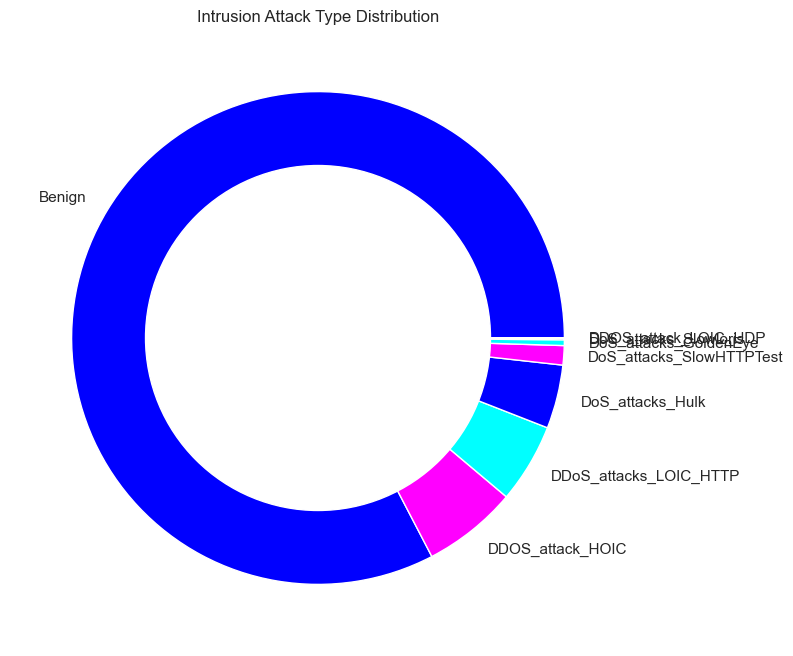

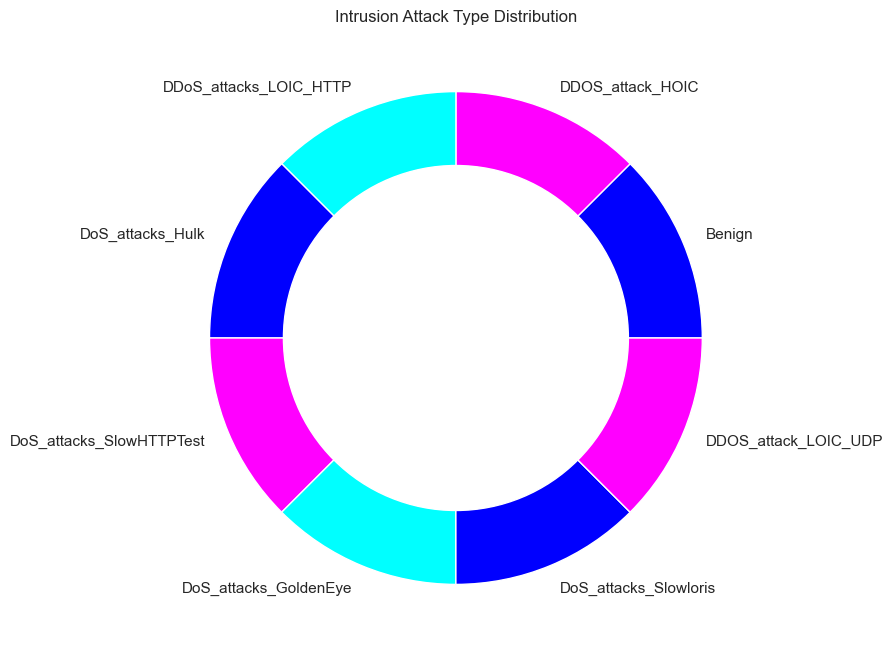

In [ ]:

plt.figure(figsize=(10, 8))
circle = plt.Circle((0, 0), 0.7, color='white')
plt.title('Intrusion Attack Type Distribution')
plt.pie(X['Label'].value_counts(), labels=["Benign","DDOS_attack_HOIC","DDoS_attacks_LOIC_HTTP","DoS_attacks_Hulk","DoS_attacks_SlowHTTPTest","DoS_attacks_GoldenEye","DoS_attacks_Slowloris","DDOS_attack_LOIC_UDP"],colors=['blue', 'magenta', 'cyan', 'blue', 'magenta', 'cyan', 'blue', 'magenta'])
p = plt.gcf()
p.gca().add_artist(circle)

# viewing the distribution of intrusion attacks in our dataset 
plt.figure(figsize=(10, 8))
circle = plt.Circle((0, 0), 0.7, color='white')
plt.title('Intrusion Attack Type Distribution')
plt.pie(train_dataset['Label'].value_counts(), labels=["Benign","DDOS_attack_HOIC","DDoS_attacks_LOIC_HTTP","DoS_attacks_Hulk","DoS_attacks_SlowHTTPTest","DoS_attacks_GoldenEye","DoS_attacks_Slowloris","DDOS_attack_LOIC_UDP"],colors=['blue', 'magenta', 'cyan', 'blue', 'magenta', 'cyan', 'blue', 'magenta'])
p = plt.gcf()
p.gca().add_artist(circle)

## splitting data to training and testing sets

In [ ]:
test_dataset = train_dataset.sample(frac=0.1)
target_train = train_dataset['Label']
target_test = test_dataset['Label']

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([6, 1, 2, 4, 0, 7, 3, 5]))

In [ ]:
y_train = to_categorical(target_train, num_classes=8)
y_test = to_categorical(target_test, num_classes=8)

print(len(y_train))
print(len(y_test))

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
[[0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [ ]:
train_dataset = train_dataset.drop(columns = ["Timestamp", "Protocol","PSH Flag Cnt","Init Fwd Win Byts","Flow Byts/s","Flow Pkts/s", "Label"], axis=1)
test_dataset = test_dataset.drop(columns = ["Timestamp", "Protocol","PSH Flag Cnt","Init Fwd Win Byts","Flow Byts/s","Flow Pkts/s", "Label"], axis=1)

In [ ]:
# making train & test splits
X_train = train_dataset.iloc[:, :-1].values
X_test = test_dataset.iloc[:, :-1].values

array([[2.10000000e+01, 2.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.00000000e+01, 1.68100000e+04, 2.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.00000000e+01, 1.19703523e+08, 8.44230000e+04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [8.00000000e+01, 8.44000000e+02, 2.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.00000000e+01, 1.33846000e+06, 3.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.00000000e+01, 7.30168080e+07, 6.41950000e+04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(160000, 72)
(16000, 72)
(160000, 8)
(16000, 8)


In [ ]:
# reshape the data for th model
X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)
X_train.shape, X_test.shape

((160000, 72, 1), (16000, 72, 1))

In [ ]:
from keras.layers import LSTM
def model():
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=True, input_shape=(72, 1)))
    model.add(BatchNormalization())
    
    model.add(LSTM(units=64, return_sequences=True))
    model.add(BatchNormalization())
    
    model.add(LSTM(units=64))
    model.add(BatchNormalization())
    
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(8, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
model = model()
model.summary()

C:\Users\doo\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 72, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 72, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 72, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,552 (361.53 KB)

 Trainable params: 92,168 (360.03 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
his = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 186s 36ms/step - accuracy: 0.9569 - loss: 0.1563 - val_accuracy: 0.9905 - val_loss: 0.0463
Epoch 2/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 175s 35ms/step - accuracy: 0.9914 - loss: 0.0354 - val_accuracy: 0.9906 - val_loss: 0.0329
Epoch 3/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 184s 37ms/step - accuracy: 0.9918 - loss: 0.0349 - val_accuracy: 0.9967 - val_loss: 0.0177
Epoch 4/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 201s 40ms/step - accuracy: 0.9944 - loss: 0.0248 - val_accuracy: 0.9948 - val_loss: 0.0230
Epoch 5/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 185s 37ms/step - accuracy: 0.9950 - loss: 0.0246 - val_accuracy: 0.9958 - val_loss: 0.0269
Epoch 6/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 199s 40ms/step - accuracy: 0.9942 - loss: 0.0273 - val_accuracy: 0.9967 - val_loss: 0.0164
Epoch 7/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 202s 40ms/step - accuracy: 0.9950 - loss: 0.0228 - val_accuracy: 0.9908 - val_loss: 0.0304
Epoch 8/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 189s 38ms/step - accuracy: 

## Results

In [ ]:
scores = model.evaluate(X_test, y_test)
print(scores)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

NameError: name 'model' is not defined

In [ ]:
history = his.history
history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

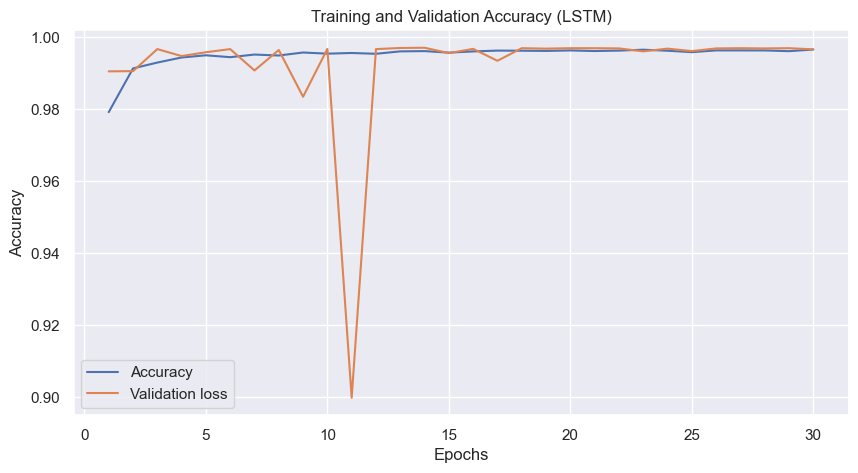

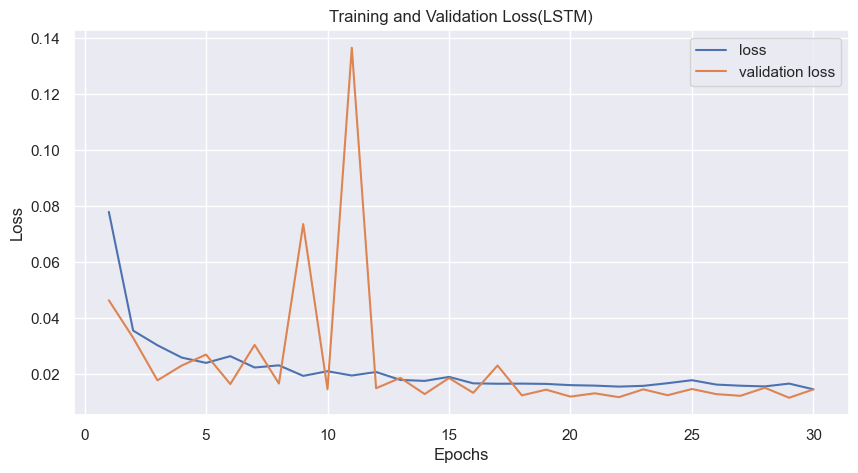

In [ ]:
epochs = range(1, len(history['loss']) + 1)
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

# visualize training and val accuracy
plt.figure(figsize=(10, 5))
plt.title('Training and Validation Accuracy (LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='Accuracy')
plt.plot(epochs, val_acc, label='Validation loss')
plt.legend()

# visualize train and val loss
plt.figure(figsize=(10, 5))
plt.title('Training and Validation Loss(LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.legend()